In [ ]:
00import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/stroke/healthcare-dataset-stroke-data.csv')

In [ ]:
data = data.drop(columns=['id'])

In [ ]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


**1. Basic information of the dataset**

In [ ]:
#return the missing rate of each column
def missing_rate(data: pd.DataFrame) -> dict:
    rate = {}
    for i in data.columns:
        rate[i] = (data[i].isnull().sum()/data.shape[0]).round(4)
    return rate

#find the features with missing values
def detect_missed(rate: dict) -> list:
    features = []
    for feature in rate.keys():
        if rate[feature] > 0:
            features.append(feature)
    return features

#figure out the number of different types in this dataset
def type_summary(data: pd.DataFrame) -> dict:
    summary = {}
    ele = list(data.loc[0])
    for i in ele:
        t = type(i)
        if t not in summary.keys():
            summary[t] = 1
        else:
            summary[t] += 1
    return summary

#find out features in each type
def detect_type(all_type: dict, data: pd.DataFrame) -> list:
    Type = {}
    for target_type in all_type.keys():
        ele = list(data.loc[3])
        features = []
        for index, e in enumerate(ele):
            if type(e) == target_type:
                features.append(data.columns[index])
            Type[target_type] = features
    return Type

#count the categories of the string data
def string_category(data: pd.DataFrame, feature: str) -> dict:
  content = data[feature]
  cate = set(content)
  return cate

In [ ]:
miss_rate = missing_rate(data)
miss_feature = detect_missed(miss_rate)
feature_summary = type_summary(data)
feature_type = detect_type(feature_summary, data)
print(f'Feature with missing data: {miss_feature}')
print(f'Missing rate: {miss_rate}')
print(f'Feature type summary: {feature_summary}')
print(f'Feature in each type: {feature_type}')
for i in feature_type[str]:
  print(f'{i}: {string_category(data, i)}')

Feature with missing data: ['bmi']
Missing rate: {'gender': 0.0, 'age': 0.0, 'hypertension': 0.0, 'heart_disease': 0.0, 'ever_married': 0.0, 'work_type': 0.0, 'Residence_type': 0.0, 'avg_glucose_level': 0.0, 'bmi': 0.0393, 'smoking_status': 0.0, 'stroke': 0.0}
Feature type summary: {<class 'str'>: 5, <class 'numpy.float64'>: 3, <class 'numpy.int64'>: 3}
Feature in each type: {<class 'str'>: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], <class 'numpy.float64'>: ['age', 'avg_glucose_level', 'bmi'], <class 'numpy.int64'>: ['hypertension', 'heart_disease', 'stroke']}
gender: {'Other', 'Male', 'Female'}
ever_married: {'Yes', 'No'}
work_type: {'Never_worked', 'children', 'Govt_job', 'Self-employed', 'Private'}
Residence_type: {'Rural', 'Urban'}
smoking_status: {'smokes', 'formerly smoked', 'Unknown', 'never smoked'}


In [ ]:
data = data.dropna()
original = data.copy()
print('Data shape is: ', data.shape)
print('Number of positive label: ', data['stroke'].value_counts()[1])
print('Number of negative label: ', data['stroke'].value_counts()[0])
209 / (209+4700)

Data shape is:  (4909, 11)
Number of positive label:  209
Number of negative label:  4700


0.04257486249745366

From this part, we can see that:
1. The dataset is highly imbalanced.
2. There are only numeric data and categorical data, no natural language data like user comments.
3. Missing rate is low, we can drop the missing data directly.

**2. Visualization**

2.1 Heat map of numeric features

<ipython-input-14-f42bb7b8fc81>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='Blues')


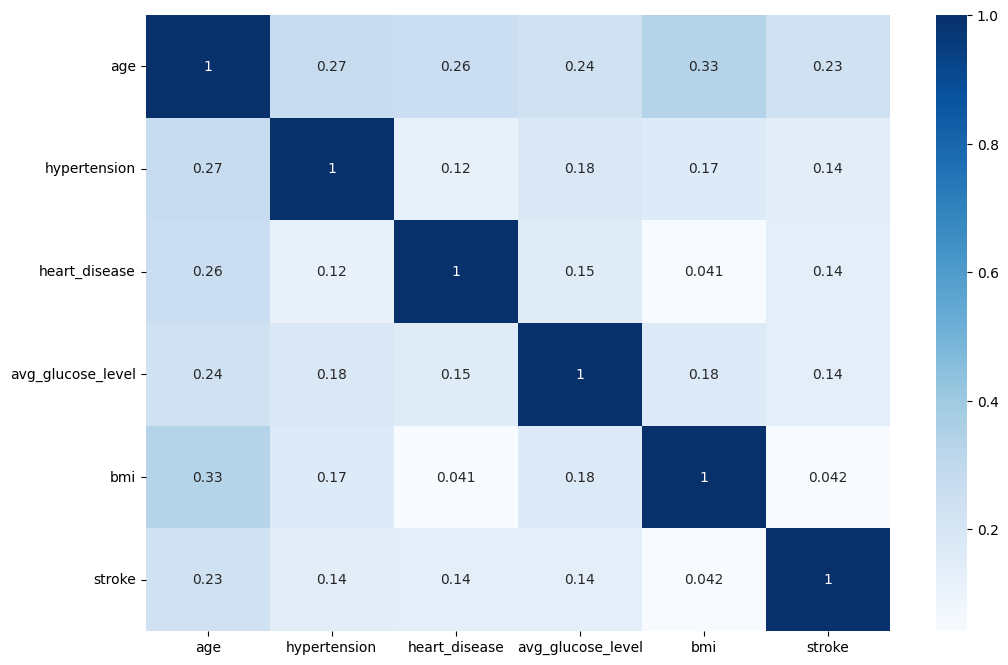

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='Blues')
plt.show()

2.2 Pariplot

<Figure size 1200x800 with 0 Axes>

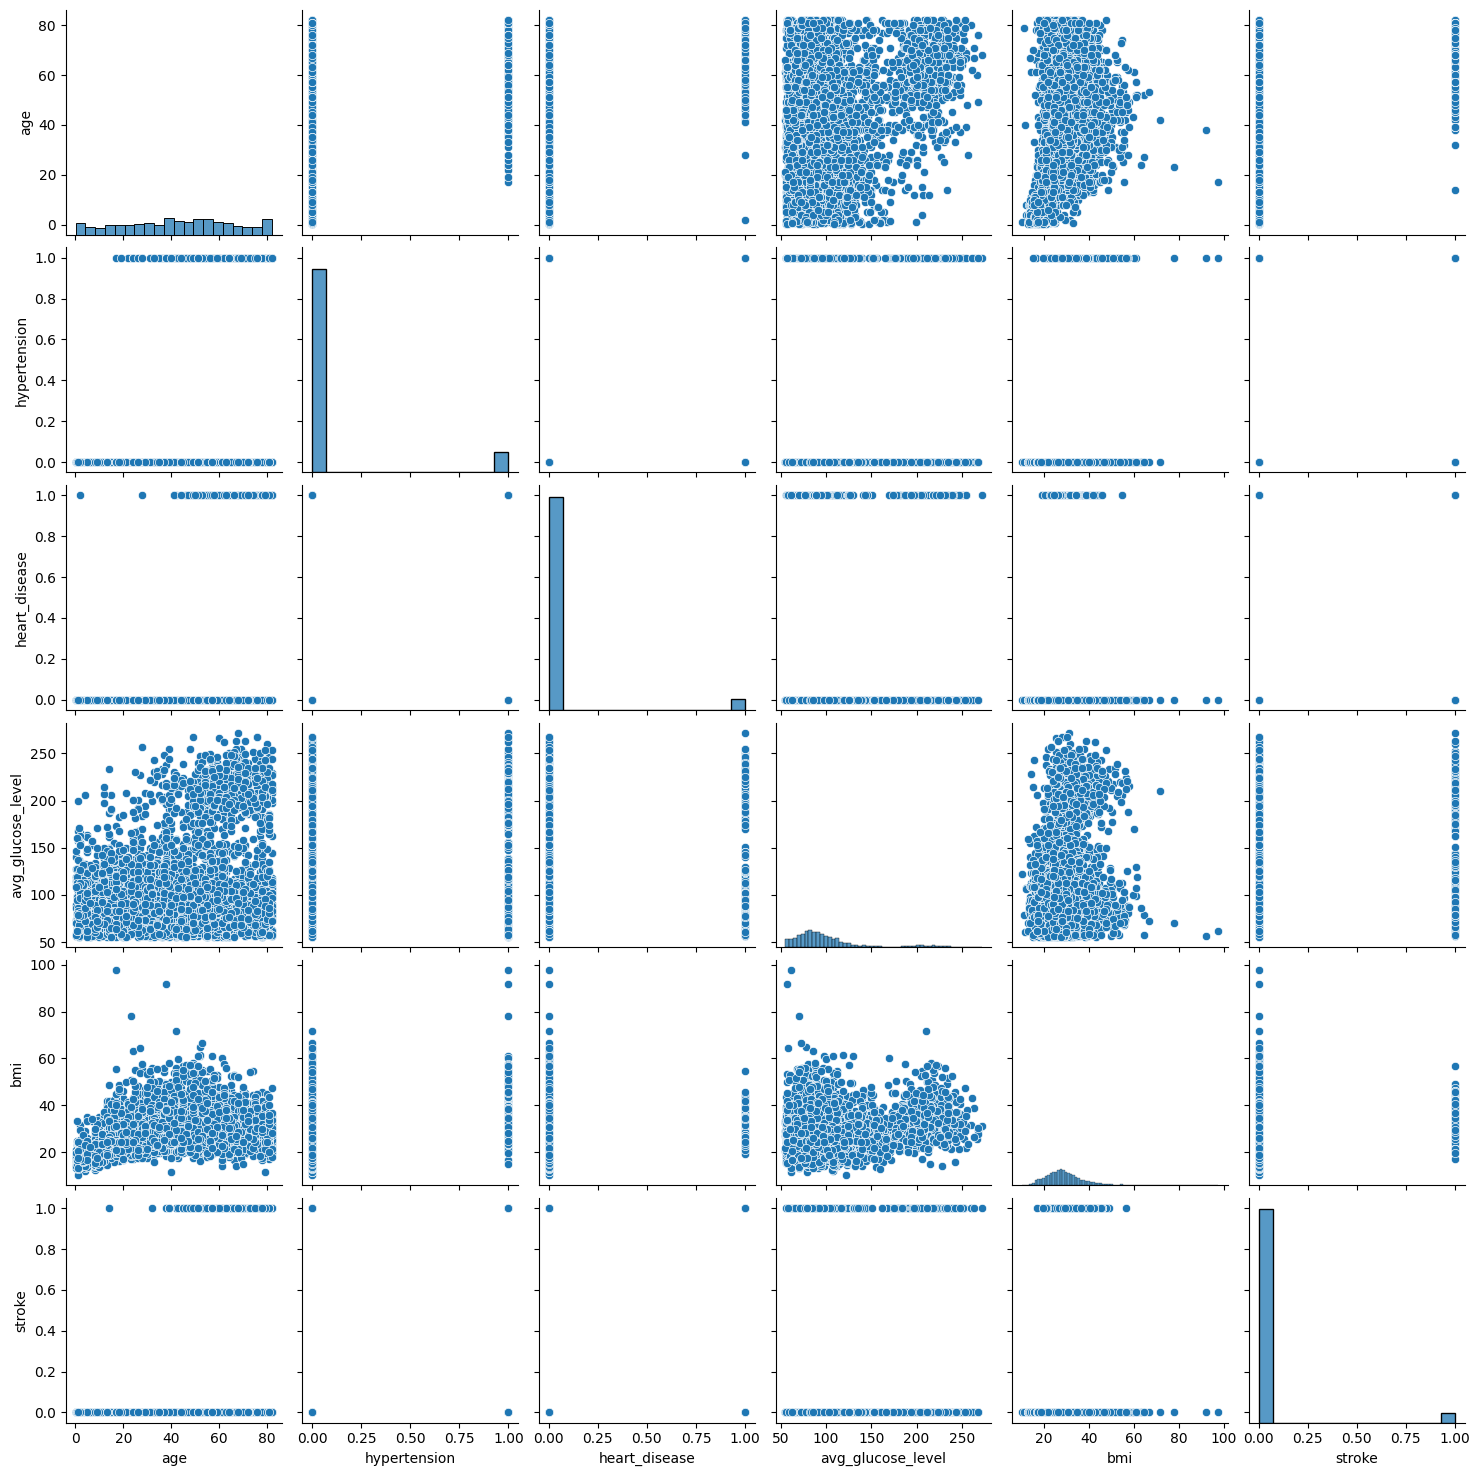

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.pairplot(data)
plt.show()

2.3 Histplot for smoke (Simpson Paradox)

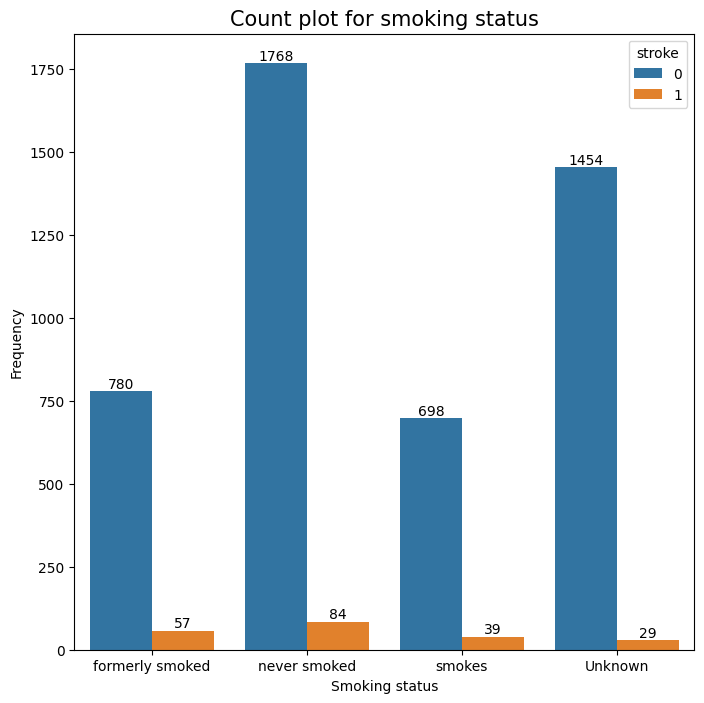

In [ ]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x='smoking_status', hue='stroke',data=original)
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Smoking status')
plt.ylabel('Frequency')
plt.title('Count plot for smoking status', fontsize=15)
plt.show()

In [ ]:
smoking_status = original[original['smoking_status'].isin(['formerly smoked', 'smokes'])]
smoking_table = pd.crosstab(smoking_status['smoking_status'], smoking_status['stroke'])
smoking_table.loc['total'] = smoking_table.sum(axis=0)
smoking_table['rate'] = smoking_table[1] / (smoking_table[0] + smoking_table[1])
smoking_table

stroke,0,1,rate
smoking_status,,,
formerly smoked,780,57,0.068100
smokes,698,39,0.052917
total,1478,96,0.060991


In [ ]:
formerly_smoked = original[original['smoking_status'] == 'formerly smoked']
smokes = original[original['smoking_status'] == 'smokes']
age_formerly = np.mean(formerly_smoked['age'])
age_smokes = np.mean(smokes['age'])

formerly_stroke = formerly_smoked[formerly_smoked['stroke'] == 1]
smokes_stroke = smokes[smokes['stroke'] == 1]
age_formerly_stroke = np.mean(formerly_stroke['age'])
age_smokes_stroke = np.mean(smokes_stroke['age'])

print(f'The average age of formerly smoked people is {age_formerly} while the average age of smoked people is {age_smokes}')
print(f'The average age of formerly smoked people who have stroked is {age_formerly_stroke} while the average age of smoked people who have stroked is {age_smokes_stroke}')

The average age of formerly smoked people is 54.92353643966547 while the average age of smoked people is 46.98643147896879
The average age of formerly smoked people who have stroked is 68.35087719298245 while the average age of smoked people who have stroked is 62.38461538461539


2.4 Histplot for marriage (Correlation != Casuality)

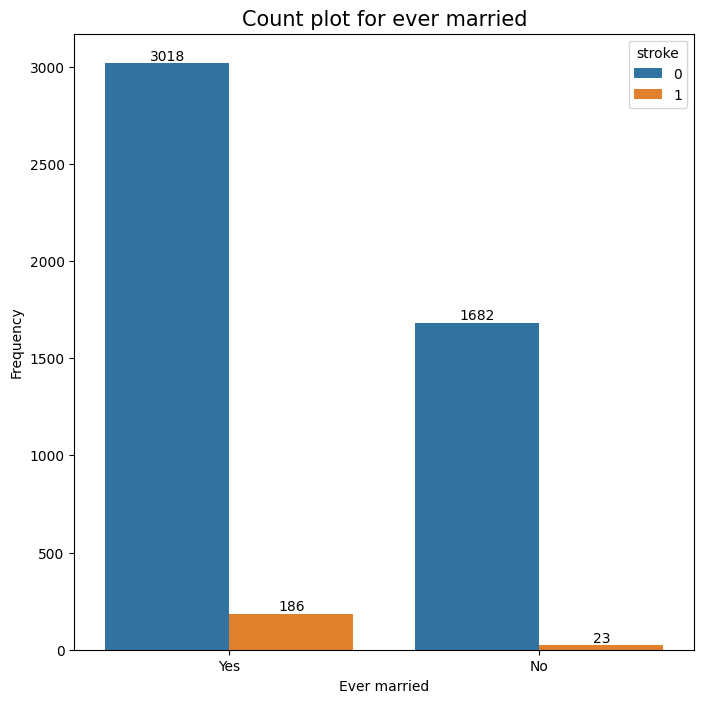

In [ ]:
# Create the count or bar plot
plt.figure(figsize=(8,8))
ax = sns.countplot(x='ever_married', hue='stroke',data=original)
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Ever married')
plt.ylabel('Frequency')
plt.title('Count plot for ever married', fontsize=15)
# Show the plot
plt.show()

In [ ]:
married = original[original['ever_married'] == 'Yes']
single = original[original['ever_married'] == 'No']
age_married = np.mean(married['age'])
age_single = np.mean(single['age'])

married_stroke = married[married['stroke'] == 1]
single_stroke = single[single['stroke'] == 1]
age_married_stroke = np.mean(married_stroke['age'])
age_single_stroke = np.mean(single_stroke['age'])

print(f'The average age of people who have gotten married is {age_married} while the average age of people who are always single is {age_single}')
print(f'The average age of people who have gotten married and stroked is {age_married_stroke} while the average age of people who have gotten married and stroked is {age_single_stroke}')

The average age of people who have gotten married is 54.06554307116105 while the average age of people who are always single is 21.818252199413486
The average age of people who have gotten married and stroked is 67.86021505376344 while the average age of people who have gotten married and stroked is 66.52173913043478


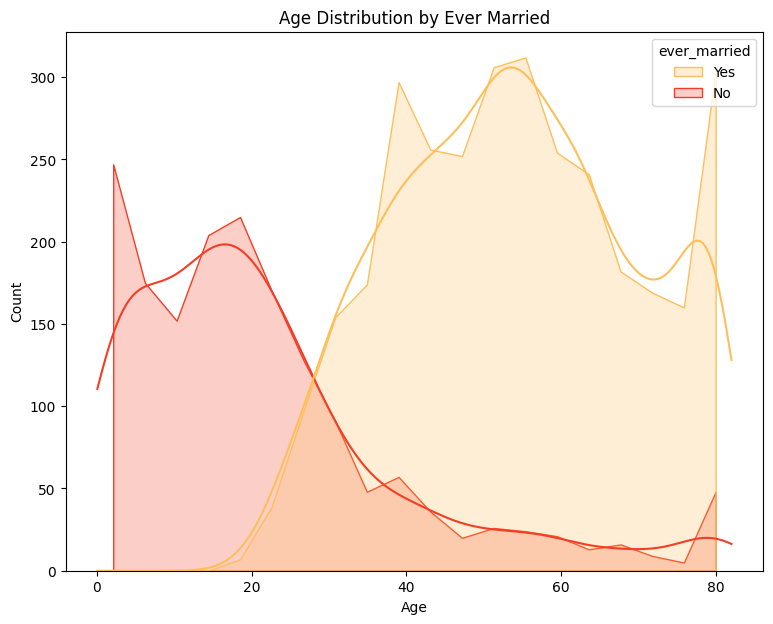

In [ ]:
import matplotlib.pyplot as plt
# Create a grid of subplots
plt.figure(figsize = (9,7))
# Plot the age distribution on the first subplot
sns.histplot(data=original, x="age", hue="ever_married", palette="YlOrRd", kde=True, element="poly")
plt.title("Age Distribution by Ever Married")
plt.xlabel("Age")
plt.ylabel("Count")

# Show the plot
plt.show()

**3. Preprocess**

3.1 Standarization

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

numeric_features = ['age', 'avg_glucose_level', 'bmi']
for column in numeric_features:
    data[column] = MinMaxScaler().fit_transform(np.array(data[column]).reshape(-1,1))

<ipython-input-208-37b78bc1797e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = MinMaxScaler().fit_transform(np.array(data[column]).reshape(-1,1))
<ipython-input-208-37b78bc1797e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = MinMaxScaler().fit_transform(np.array(data[column]).reshape(-1,1))
<ipython-input-208-37b78bc1797e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,0.816895,0,1,Yes,Private,Urban,0.801265,0.301260,formerly smoked,1
2,Male,0.975586,0,1,Yes,Private,Rural,0.234512,0.254296,never smoked,1
3,Female,0.597168,0,0,Yes,Private,Urban,0.536008,0.276060,smokes,1
4,Female,0.963379,1,0,Yes,Self-employed,Rural,0.549349,0.156930,never smoked,1
5,Male,0.987793,0,0,Yes,Private,Urban,0.605161,0.214204,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,0.157715,0,0,No,children,Rural,0.221402,0.095074,Unknown,0
5106,Female,0.987793,0,0,Yes,Self-employed,Urban,0.323516,0.340206,never smoked,0
5107,Female,0.426270,0,0,Yes,Self-employed,Rural,0.128658,0.232532,never smoked,0
5108,Male,0.621582,0,0,Yes,Private,Rural,0.513203,0.175258,formerly smoked,0


3.2 dummy variables


In [ ]:
feature_summary = type_summary(data)
feature_type = detect_type(feature_summary, data)
for i in feature_type[str]:
    dummy = pd.get_dummies(data[i], prefix=i)
    data = pd.concat([data, dummy], axis=1)
    data = data.drop(i, axis = 1)

In [ ]:
data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.816895,0,1,0.801265,0.301260,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
2,0.975586,0,1,0.234512,0.254296,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,0.597168,0,0,0.536008,0.276060,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0.963379,1,0,0.549349,0.156930,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
5,0.987793,0,0,0.605161,0.214204,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.157715,0,0,0.221402,0.095074,0,1,0,0,1,...,0,0,0,1,1,0,1,0,0,0
5106,0.987793,0,0,0.323516,0.340206,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,0.426270,0,0,0.128658,0.232532,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,0.621582,0,0,0.513203,0.175258,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


3.3 Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X = data.drop('stroke', axis=1)
y = data['stroke']
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
print('Train data shape is: ', X_resampled.shape)
print('Ratio of y_train: ', y_resampled.value_counts()[1]/y_resampled.value_counts()[0])

Train data shape is:  (9400, 21)
Ratio of y_train:  1.0


3.4 Data split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print('Train data shape is: ', X_train.shape)
print('Test data shape is: ', X_test.shape)
print('Ratio of y_train: ', y_train.value_counts()[1]/y_train.value_counts()[0])
print('Ratio of y_test: ', y_test.value_counts()[1]/y_test.value_counts()[0])

Train data shape is:  (7520, 21)
Test data shape is:  (1880, 21)
Ratio of y_train:  1.0
Ratio of y_test:  1.0


**4. Modeling**

4.1 Metrics

In [ ]:
def evaluate(predicted, y_test) -> dict:
    accuracy = accuracy_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    pre = precision_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)
    result = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": pre,
        "F1 score": f1
    }
    return result

def output_result(result: dict) -> None:
    for metrics, value in result.items():
        print(metrics, value)

4.2 Logistic Regression

In [ ]:
def logistic(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, threshold: float) -> dict:
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    is_cancel_proba = [y_pred_proba[i][1] for i in range(y_pred_proba.shape[0])]
    predicted = [i > threshold for i in is_cancel_proba]
    result = evaluate(predicted, y_test)
    print('Below are the results for logistic:')
    return result, y_pred_proba

In [ ]:
logistic_result, y_pred_proba = logistic(X_train, y_train, X_test, y_test, 0.4)
print(output_result(logistic_result))

Below are the results for logistic:
Accuracy 0.8287234042553191
Recall 0.9117021276595745
Precision 0.781934306569343
F1 score 0.8418467583497053
None


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


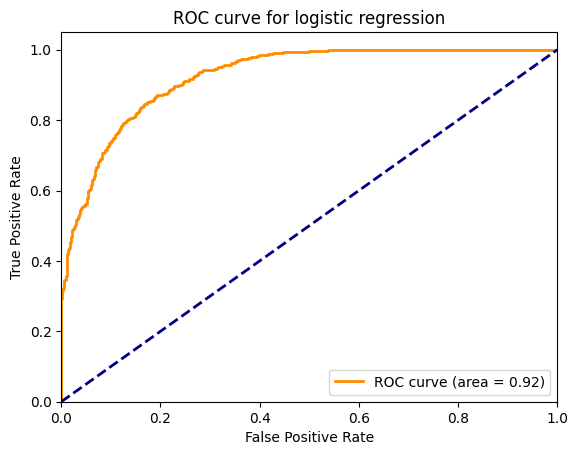

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_score, title):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

y_score = [y_pred_proba[i][1] for i in range(y_pred_proba.shape[0])]
plot_roc_curve(y_test, y_score, 'ROC curve for logistic regression')


4.3 Random Forest

In [ ]:
def cv_RF(X_train, y_train):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        decisionTree_grid = RandomForestClassifier()
        param_grid = {
            'n_estimators': [30, 50, 100, 200, 400, 500, 1000],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 15, 20, 25],
            'min_samples_split': [1, 2, 5, 10],
            'min_samples_leaf': [1, 2, 5, 10],
        }

        grid_search = GridSearchCV(decisionTree_grid, param_grid, scoring = 'f1', cv = 5)
        grid_search.fit(X_train, y_train)
        print("The best hyper-parameter combinations:", grid_search.best_params_)
        print("The corresponding accuracy:", grid_search.best_score_)

In [ ]:
import pandas as pd
def random_forest(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> dict:
    model = RandomForestClassifier(criterion='entropy', max_depth= None, random_state = 1111, min_samples_leaf= 1, min_samples_split= 5, n_estimators=500)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    result = evaluate(predicted, y_test)
    print('Below are the results for random forest:')
    return result, model

In [ ]:
random_forest_result, model = random_forest(X_train, y_train, X_test, y_test)
print(output_result(random_forest_result))

Below are the results for random forest:
Accuracy 0.9436170212765957
Recall 0.9744680851063829
Precision 0.9178356713426854
F1 score 0.9453044375644994
None


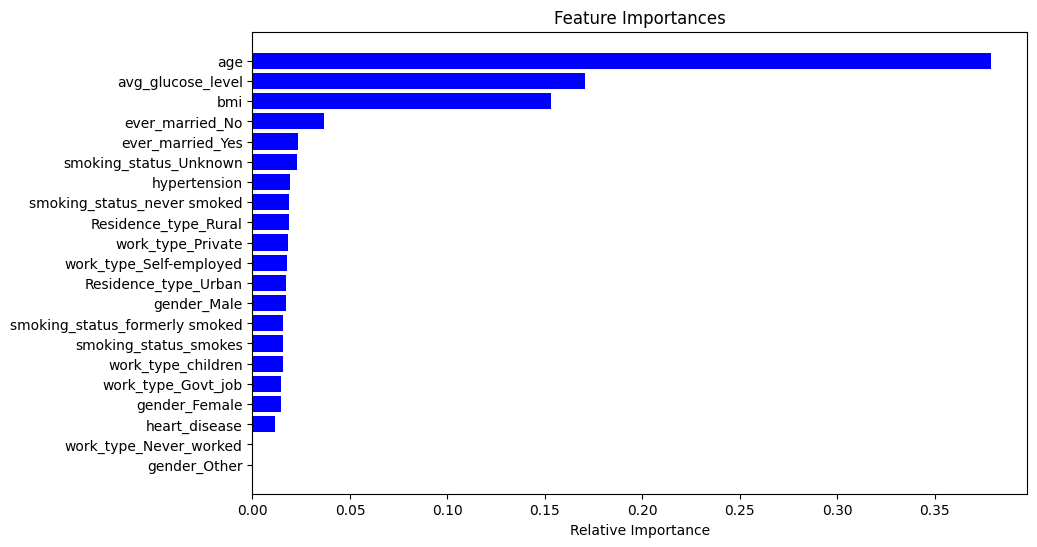

In [ ]:
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**ICA**

In [ ]:
continuous = data[['age', 'avg_glucose_level', 'bmi']]
ica = FastICA(n_components=3)
S = ica.fit_transform(continuous)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


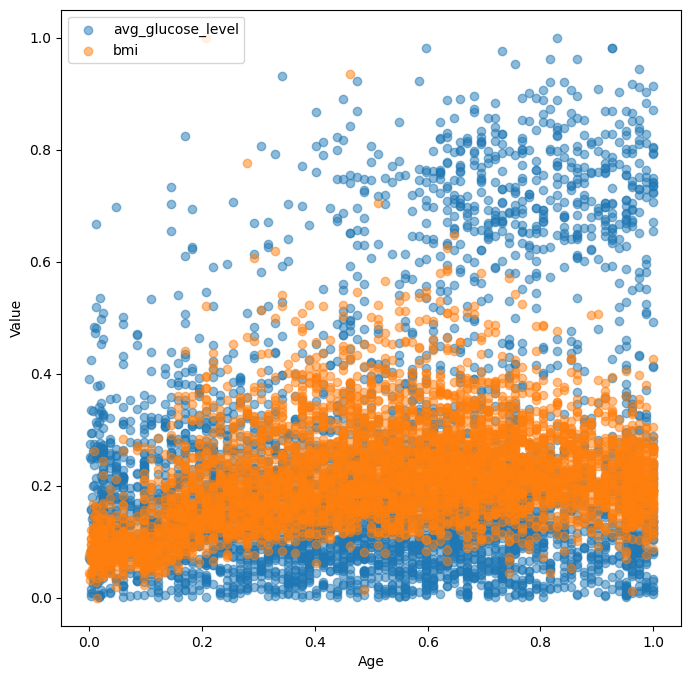

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(data['age'], data['avg_glucose_level'], alpha=0.5)
plt.scatter(data['age'], data['bmi'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Value')
plt.legend(['avg_glucose_level', 'bmi'])
plt.show()


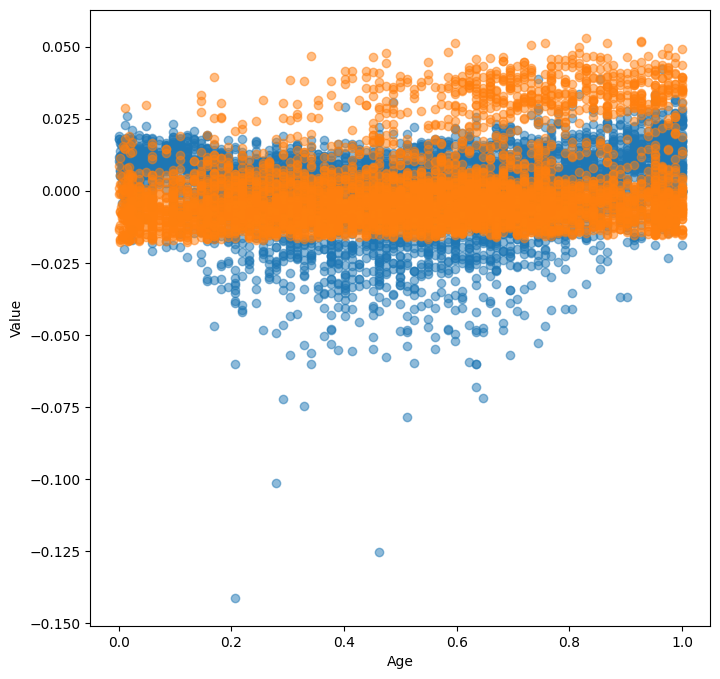

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(data['age'], S[:, 1], alpha=0.5)
plt.scatter(data['age'], S[:, 2], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Value')
plt.show()

In [ ]:
X_ica = data.drop('stroke', axis=1)
y_ica = data['stroke']
X_ica['avg_glucose_level'] = S[:, 1]
X_ica['bmi'] = S[:, 2]
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled_ica, y_resampled_ica = smote.fit_resample(X_ica, y_ica)
numeric_features = ['age', 'avg_glucose_level', 'bmi']
for column in numeric_features:
    X_resampled_ica[column] = MinMaxScaler().fit_transform(np.array(X_resampled_ica[column]).reshape(-1,1))

In [ ]:
X_train_ica, X_test_ica, y_train_ica, y_test_ica = train_test_split(X_resampled_ica, y_resampled_ica, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
def random_forest(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> dict:
    model = RandomForestClassifier(criterion='entropy', max_depth= None, random_state = 1111, min_samples_leaf= 1, min_samples_split= 2, n_estimators=500)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    result = evaluate(predicted, y_test)
    print('Below are the results for random forest:')
    return result, model
random_forest_result, model = random_forest(X_train_ica, y_train_ica, X_test_ica, y_test_ica)
print(output_result(random_forest_result))

Below are the results for random forest:
Accuracy 0.9409574468085107
Recall 0.9702127659574468
Precision 0.9165829145728643
F1 score 0.9426356589147287
None


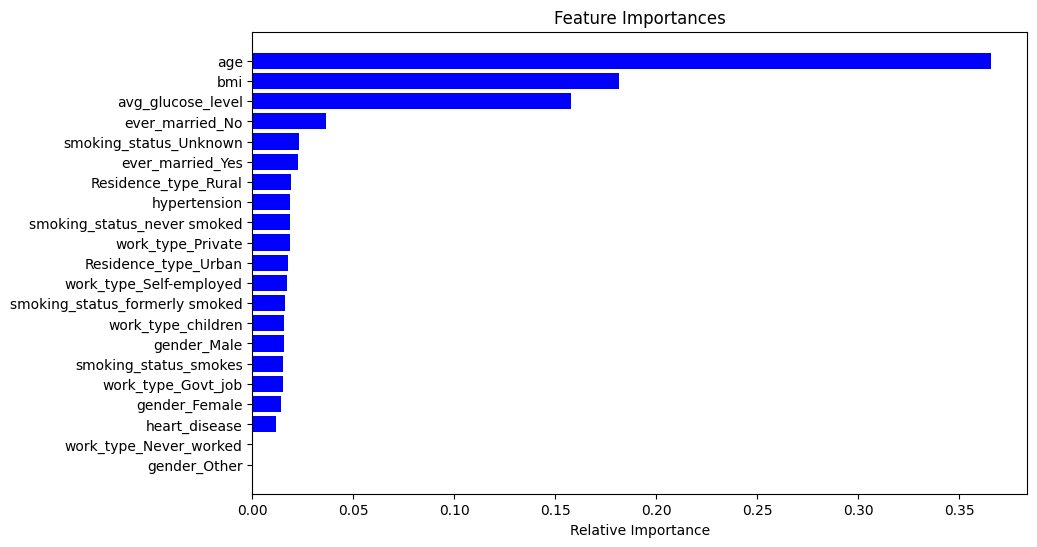

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In addition to the current data, we hope to comprehensively collect more data in the future, including:
1. Body fat percentage: Because BMI only reflects whether a person's total body weight is normal, but cannot reflect the composition of this weight. For example, for two individuals with the same weight of 70kg, one with predominantly muscle and the other with predominantly fat, their respective probabilities of having a stroke are different.
2. Blood pressure: We not only want to know if the customer has high blood pressure, but also want to know the specific numerical value. Because although blood pressures of 140mmHg and 220mmHg are both considered high blood pressure, the probability of stroke is different.
3. Blood lipid levels: High blood lipids can lead to blood vessel blockage, greatly increasing the probability of stroke.

Logic of our project:
1. We use random forest to calculate the importance of each feature.
2. We found that age is the most important and the marital status is also very important. We want to explore the reason behind.
3. We think age is the most important because age will influence many indexes that will directly influence the probability of getting stroked. (Now display the imteresting finding we got)
4. For continuous features, we can use ICA to remove the influence of age. After doing that, we can see that the importance of bmi becomes higher than glucose level. We deduce the reason is that high glucose level is always connected to high age. So if we remove the influence of age, its importance decreases.